In [1]:
# Imports
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, chi2_contingency, pointbiserialr
from sklearn.metrics import matthews_corrcoef
import numpy as np
from sklearn import preprocessing
import math

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
# Read data
dir_data = '../../data/raw/'

# File names
filename_train_features = 'train_values.csv'

# Create paths for given files
filepath_train_features = os.path.join(dir_data, filename_train_features)

# Check if files and data folder exist
if not os.path.isdir(dir_data):
    raise FileNotFoundError("Data directory is missing")
if not len(os.listdir(dir_data)):
    raise FileNotFoundError("Files missing")

if not filepath_train_features:
    raise FileNotFoundError(f"{filename_train_features} is missing.")

# Load data
data = pd.read_csv(filepath_train_features)

y_train = pd.read_csv("../../data/raw/train_labels.csv")

In [4]:
df = data.set_index('building_id').join(y_train.set_index('building_id'))

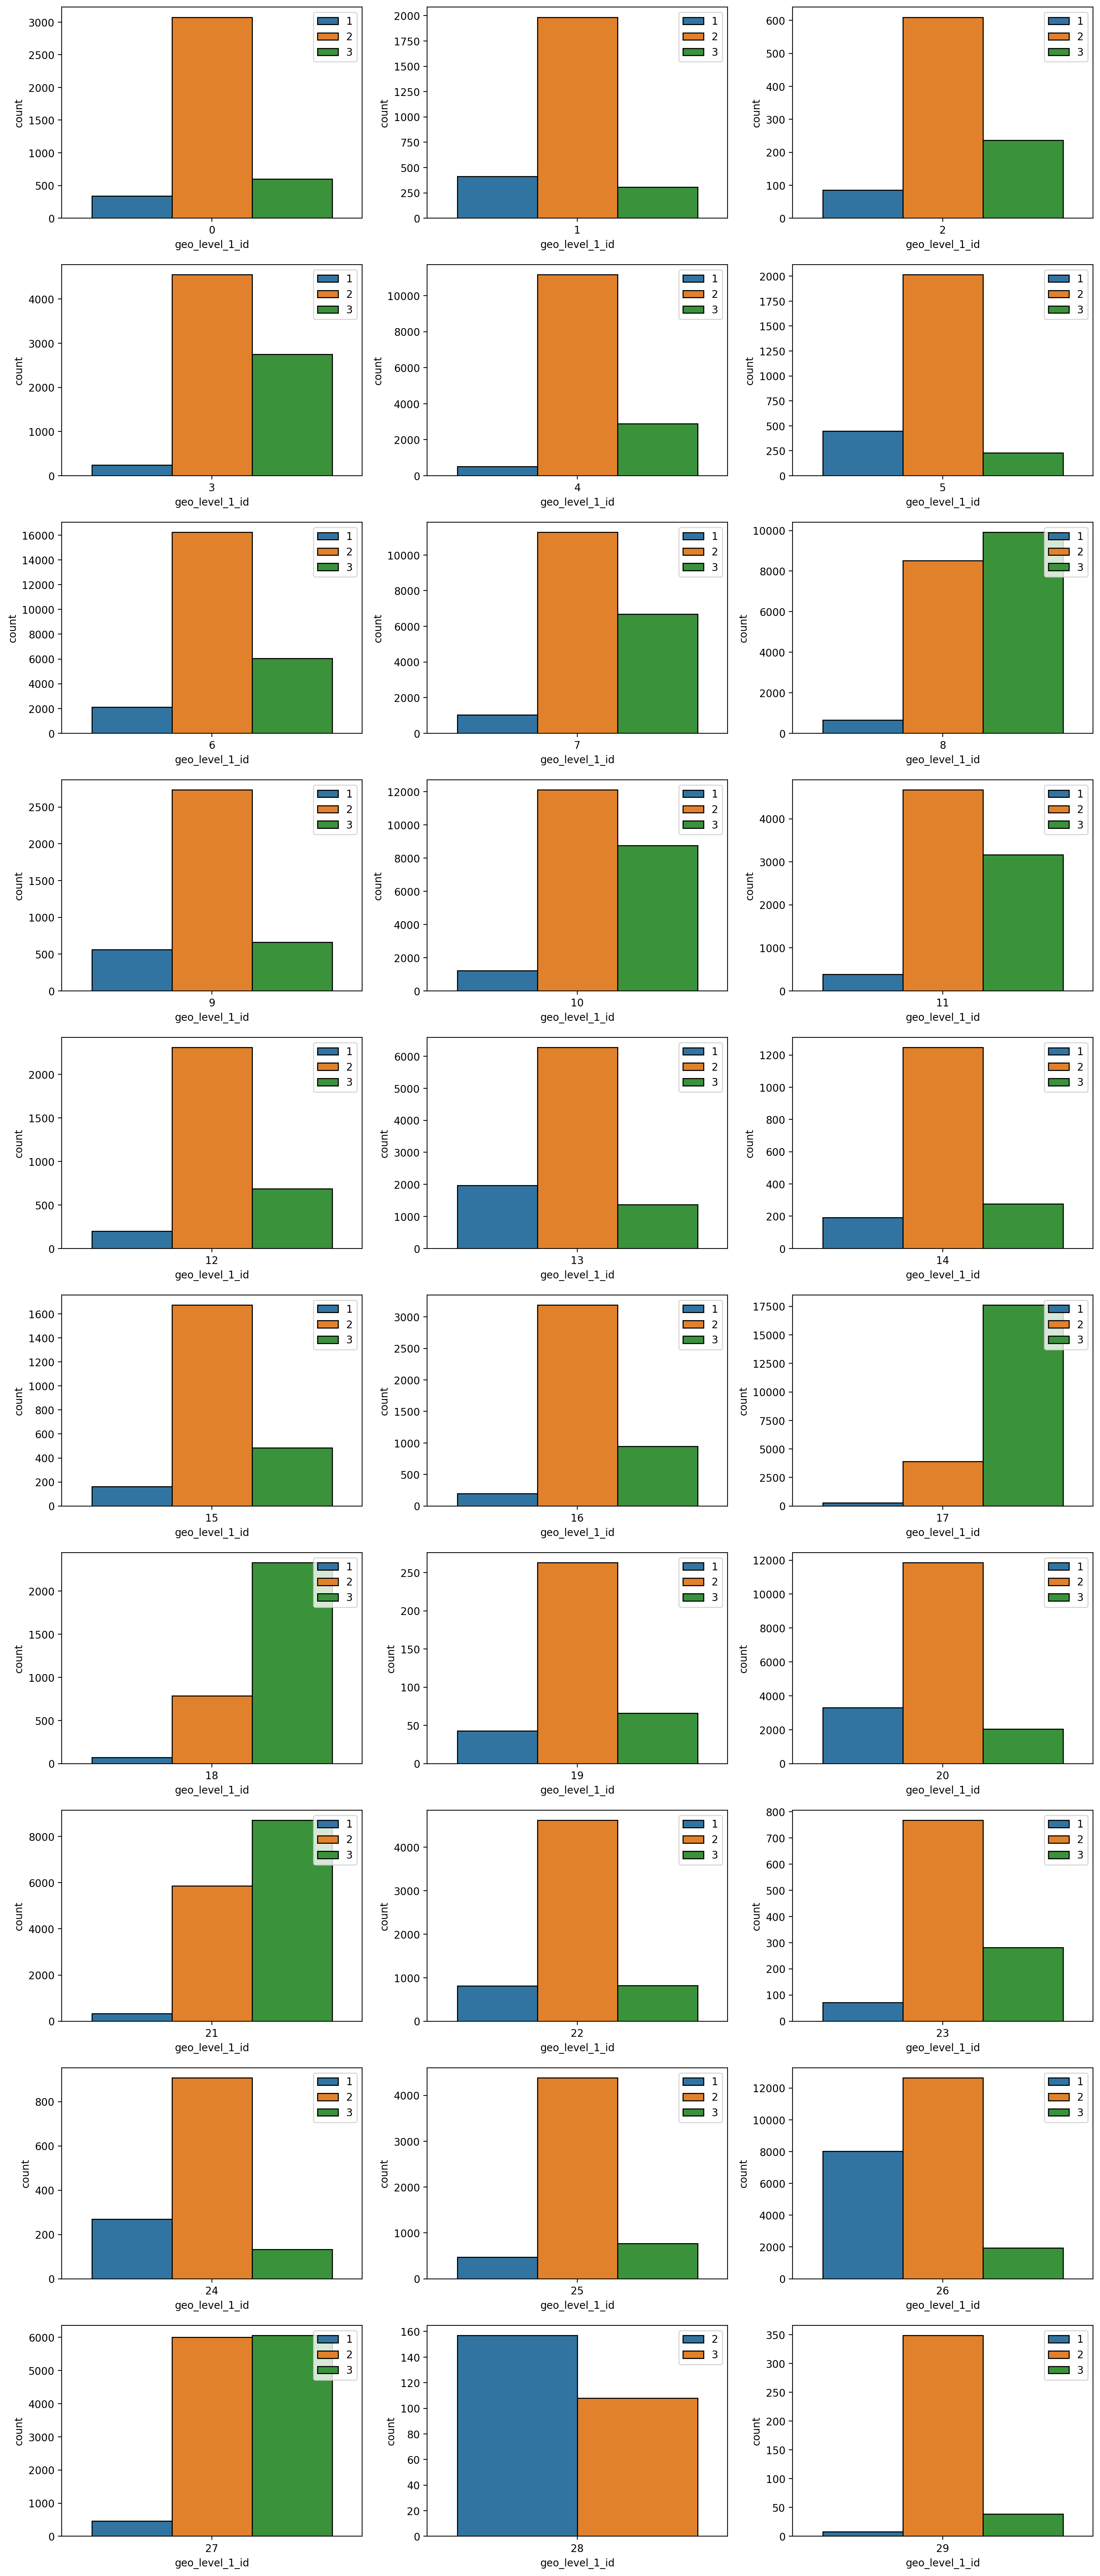

In [5]:
fig, axes = plt.subplots(figsize=(15, 35), nrows=10, ncols=3)
axes = axes.flatten()

for geo_level in range(30):
    data_filtered = df[df['geo_level_1_id'] == geo_level]
    
    g=sns.countplot(data=data_filtered, x='geo_level_1_id', hue="damage_grade", edgecolor="black", ax=axes[geo_level])
    axes[geo_level].legend(loc="upper right")
    
plt.tight_layout()
plt.show()

## Calculate statistics for geo_level_1_id

In [14]:
unique_geo_level_1_ids = pd.DataFrame(data={"geo_level_1_id": df["geo_level_1_id"].unique()})

In [15]:
unique_damage_grades = pd.DataFrame(data={"damage_grade": df["damage_grade"].unique()})

In [16]:
# Cross join
unique_geo_level_1_ids["key"] = 0
unique_damage_grades["key"] = 0
stats_df = unique_geo_level_1_ids.merge(unique_damage_grades, on='key', how='outer')
del stats_df["key"]

stats_df.sort_values(by=["geo_level_1_id", "damage_grade"])

,geo_level_1_id,damage_grade
23,0,1
22,0,2
21,0,3
77,1,1
76,1,2
...,...,...
91,29,2
90,29,3
59,30,1
58,30,2


In [19]:
# Lists to temporarily store the results
totals = []
damaged = []
risks = []
sample_size = []

total_samples = df.shape[0]

# Calculate stats
for _, row in stats_df.iterrows():
    t = df["geo_level_1_id"].where(df["geo_level_1_id"] == row["geo_level_1_id"]).count()
    totals.append(t)
    
    d = df["geo_level_1_id"].where((df["geo_level_1_id"] == row["geo_level_1_id"]) & (df["damage_grade"] == row["damage_grade"])).count()
    damaged.append(d)
    
    r = d / t
    risks.append(r)
    
    sample_size.append(t / total_samples)

# Add stats to dataframe
stats_df["size_of_risk_sample"] = sample_size
stats_df["risk"] = risks

# Weighted rist status
stats_df["weighted_risk_status"] = stats_df["size_of_risk_sample"] * stats_df["risk"]

# Show
stats_df

,geo_level_1_id,damage_grade,size_of_risk_sample,risk,weighted_risk_status
0,6,3,0.093557,0.248185,0.023219
1,6,2,0.093557,0.665354,0.062248
2,6,1,0.093557,0.086461,0.008089
3,8,3,0.073215,0.519549,0.038039
4,8,2,0.073215,0.446174,0.032667
...,...,...,...,...,...
88,2,2,0.003573,0.655209,0.002341
89,2,1,0.003573,0.091300,0.000326
90,29,3,0.001520,0.098485,0.000150
91,29,2,0.001520,0.881313,0.001339


In [26]:
stats_df["size_of_risk_sample"].where(stats_df["geo_level_1_id"] == 6).max()

0.09355681674283675

In [45]:
risk_df = pd.DataFrame(data={"geo_level_1_id": df["geo_level_1_id"].unique()})

risk_sample_size = []
dg1 = []
dg2 = []
dg3 = []
dg1w = []
dg2w = []
dg3w = []

for _, row in risk_df.iterrows():
    t = stats_df["size_of_risk_sample"].where(stats_df["geo_level_1_id"] == row["geo_level_1_id"]).max()
    risk_sample_size.append(t)
    
    d = stats_df["risk"].where((stats_df["geo_level_1_id"] == row["geo_level_1_id"]) & (stats_df["damage_grade"] == 1)).max()
    dg1.append(d)
    dg1w.append(d * t)
    
    d = stats_df["risk"].where((stats_df["geo_level_1_id"] == row["geo_level_1_id"]) & (stats_df["damage_grade"] == 2)).max()
    dg2.append(d)
    dg2w.append(d * t)
    
    d = stats_df["risk"].where((stats_df["geo_level_1_id"] == row["geo_level_1_id"]) & (stats_df["damage_grade"] == 3)).max()
    dg3.append(d)
    dg3w.append(d * t)

# Add info to dataframe
risk_df["risk_sample_size"] = risk_sample_size
risk_df["damage_grade_1_risk"] = dg1
risk_df["damage_grade_2_risk"] = dg2
risk_df["damage_grade_3_risk"] = dg3

risk_df["damage_grade_1_risk_weighted"] = dg1w
risk_df["damage_grade_2_risk_weighted"] = dg2w
risk_df["damage_grade_3_risk_weighted"] = dg3w

# Show
risk_df

,geo_level_1_id,risk_sample_size,damage_grade_1_risk,damage_grade_2_risk,damage_grade_3_risk,damage_grade_1_risk_weighted,damage_grade_2_risk_weighted,damage_grade_3_risk_weighted
0,6,0.093557,0.086461,0.665354,0.248185,0.008089,0.062248,0.023219
1,8,0.073215,0.034277,0.446174,0.519549,0.002510,0.032667,0.038039
2,21,0.057133,0.021627,0.393378,0.584996,0.001236,0.022475,0.033423
3,22,0.023991,0.129718,0.739603,0.130678,0.003112,0.017744,0.003135
4,11,0.031542,0.046959,0.568370,0.384672,0.001481,0.017928,0.012133
5,9,0.015188,0.141738,0.690500,0.167761,0.002153,0.010487,0.002548
6,20,0.066063,0.192321,0.688894,0.118785,0.012705,0.045510,0.007847
7,0,0.015391,0.084019,0.766642,0.149339,0.001293,0.011800,0.002299
8,26,0.086780,0.354986,0.559142,0.085872,0.030806,0.048522,0.007452
9,17,0.083703,0.013066,0.179388,0.807546,0.001094,0.015015,0.067594


# Define function

In [46]:
def get_risk_status_based_on_geo_level(data=None, labels=None, geo_level=1):
    # Get unique geo_level_ids and damage grades
    unique_geo_level_1_ids = pd.DataFrame(data={"geo_level_1_id": data["geo_level_1_id"].unique()})
    unique_damage_grades = pd.DataFrame(data={"damage_grade": labels["damage_grade"].unique()})
    
    # Cross join
    unique_geo_level_1_ids["key"] = 0
    unique_damage_grades["key"] = 0
    stats_df = unique_geo_level_1_ids.merge(unique_damage_grades, on='key', how='outer')
    del stats_df["key"]

    # Lists to temporarily store the results
    totals = []
    damaged = []
    risks = []
    sample_size = []

    total_samples = df.shape[0]

    # Calculate stats
    for _, row in stats_df.iterrows():
        t = df["geo_level_1_id"].where(df["geo_level_1_id"] == row["geo_level_1_id"]).count()
        totals.append(t)

        d = df["geo_level_1_id"].where((df["geo_level_1_id"] == row["geo_level_1_id"]) & (df["damage_grade"] == row["damage_grade"])).count()
        damaged.append(d)

        r = d / t
        risks.append(r)

        sample_size.append(t / total_samples)

    # Add stats to dataframe
    stats_df["size_of_risk_sample"] = sample_size
    stats_df["risk"] = risks

    # Weighted rist status
    stats_df["weighted_risk_status"] = stats_df["size_of_risk_sample"] * stats_df["risk"]
    
    # Transform dataframe to the right format to join it to the data
    risk_df = pd.DataFrame(data={"geo_level_1_id": df["geo_level_1_id"].unique()})
    
    # Lists for temporary results
    risk_sample_size = []
    dg1 = []
    dg2 = []
    dg3 = []
    dg1w = []
    dg2w = []
    dg3w = []
    
    # Look up temporary results and add them to the risk dataframe
    for _, row in risk_df.iterrows():
        t = stats_df["size_of_risk_sample"].where(stats_df["geo_level_1_id"] == row["geo_level_1_id"]).max()
        risk_sample_size.append(t)

        d = stats_df["risk"].where((stats_df["geo_level_1_id"] == row["geo_level_1_id"]) & (stats_df["damage_grade"] == 1)).max()
        dg1.append(d)
        dg1w.append(d * t)

        d = stats_df["risk"].where((stats_df["geo_level_1_id"] == row["geo_level_1_id"]) & (stats_df["damage_grade"] == 2)).max()
        dg2.append(d)
        dg2w.append(d * t)

        d = stats_df["risk"].where((stats_df["geo_level_1_id"] == row["geo_level_1_id"]) & (stats_df["damage_grade"] == 3)).max()
        dg3.append(d)
        dg3w.append(d * t)

    # Add info to dataframe
    risk_df["risk_sample_size"] = risk_sample_size
    risk_df["damage_grade_1_risk"] = dg1
    risk_df["damage_grade_2_risk"] = dg2
    risk_df["damage_grade_3_risk"] = dg3

    risk_df["damage_grade_1_risk_weighted"] = dg1w
    risk_df["damage_grade_2_risk_weighted"] = dg2w
    risk_df["damage_grade_3_risk_weighted"] = dg3w
    
    # Join features to data
    result = data.merge(stats_df, on="geo_level_1_id", how="left")
    result = data.set_index('geo_level_1_id').join(risk_df.set_index('geo_level_1_id'))
    result = result.reset_index()
    
    return result

In [47]:
test = get_risk_status_based_on_geo_level(data=data, labels=y_train, geo_level=1)

In [49]:
test.head(15)

,geo_level_1_id,building_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,risk_sample_size,damage_grade_1_risk,damage_grade_2_risk,damage_grade_3_risk,damage_grade_1_risk_weighted,damage_grade_2_risk_weighted,damage_grade_3_risk_weighted
0,0,441126,757,7219,2,15,8,6,t,r,...,0,0,0,0.015391,0.084019,0.766642,0.149339,0.001293,0.0118,0.002299
1,0,529881,1274,4190,2,35,8,5,t,r,...,0,0,0,0.015391,0.084019,0.766642,0.149339,0.001293,0.0118,0.002299
2,0,325898,1274,2521,2,20,6,5,t,r,...,0,0,0,0.015391,0.084019,0.766642,0.149339,0.001293,0.0118,0.002299
3,0,285746,146,11169,2,10,4,4,t,r,...,0,0,0,0.015391,0.084019,0.766642,0.149339,0.001293,0.0118,0.002299
4,0,210904,793,104,2,30,9,7,t,r,...,0,0,0,0.015391,0.084019,0.766642,0.149339,0.001293,0.0118,0.002299
5,0,473223,1333,2671,2,15,5,5,n,r,...,0,0,0,0.015391,0.084019,0.766642,0.149339,0.001293,0.0118,0.002299
6,0,358361,757,4055,2,15,12,5,t,r,...,0,0,0,0.015391,0.084019,0.766642,0.149339,0.001293,0.0118,0.002299
7,0,290140,757,7219,2,35,8,5,t,r,...,0,0,0,0.015391,0.084019,0.766642,0.149339,0.001293,0.0118,0.002299
8,0,458252,357,1151,2,40,5,5,n,r,...,0,0,0,0.015391,0.084019,0.766642,0.149339,0.001293,0.0118,0.002299
9,0,1031836,793,4288,2,25,20,6,n,u,...,0,0,0,0.015391,0.084019,0.766642,0.149339,0.001293,0.0118,0.002299
